#### A National Land Use And Land Cover Projection For Threat Assessment And Conservation Planning
How would a business as usual growth scenario affect ecosystems across the USA, by 2061? 

#### Purpose
This biogeographical analysis package displays and summarizes a land use change projection from Kreitler and Sleeter (2018), "A national land use and land cover projection for threat assessment and conservation planning". The classified threat layer from this dataset is used to project the amount of area threatened by development in each Omernik Level III (L3) Ecoregion. Threat is defined in the data release as no/low/medium/high threat according to likelihood of developed land use change (0%, <33%, <66%, <100%, respectively). This information could be used in analyses to determine how much area is expected to transition into a developed class by for each ecoregions in the Continental USA. Further detail excerpted from the data release:

> This dataset contains a projection of land use and land cover for the conterminous United States for the period 2001 - 2061. This projection used the USGS's LUCAS (Land Use and Carbon Scenario Simulator) model to project a business as usual scenario of land cover and land use change. By running the LUCAS model on the USGS's YETI high performance computer and parallelizing the computation, we ran 100 Monte Carlo simulations based on empirically observed rates of change at a relatively fine scale (270m). We sampled from multiple observed rates of change at the county level to introduce heterogeneity into the Monte Carlo simulations. Using this approach allowed the model to project different outcomes that were summarized to produce estimates of likelihood of development at any given location. These estimates can then be used in conservation planning to determine where, and at what rate, land use change would occur according to this scenario.

#### Code
In this initial release, this code summarizes the threat facing L3 ecoregions. The script ["threatCalc.py"](https://github.com/usgs-bis/expected-land-use-change/blob/master/threatCalc.py) is an arcpy script that calculates the area of each threat class within each L3 ecoregion. Alternatively, a different shapefile or zone raster could be used in place of the L3 ecoregion boundaries to summarize the threat data at a user's desired geography. "threatCalc.py" simply summarizes the threat witin an area; to go beyond and understand the threat to ecological systems, the script "ecolSysThreatCalc.py" determines where the expected land use change will displace ecosystems at the ecological systems classification layer within each L3 ecoregion. 

#### Dependencies
The "threaCalc.py" and "ecolSysThreatCalc.py" scripts were written using Python 2.7 and arcpy 10.5.1. Future releases will use open source software.  

#### Inputs
- ["Threat.tif" from Kreitler and Sleeter (2018)](https://www.sciencebase.gov/catalog/item/5a87249de4b00f54eb3a2e1e)
- ["DevelopmentPercent2061.tif" from Kreitler and Sleeter (2018)](https://www.sciencebase.gov/catalog/item/5a87249de4b00f54eb3a2e1e)
- [Ecological systems from GAP](https://gapanalysis.usgs.gov/gaplandcover/data/)
- [Omernik level 3 ecoregions from EPA](https://www.epa.gov/eco-research/level-iii-and-iv-ecoregions-continental-united-states)

#### Outputs
- [Threat by Ecoregions](https://github.com/usgs-bis/expected-land-use-change/blob/readme-edits.md/Threat_30m_L3_Ecoregions.txt) Tabular output of area in the High, Med, Low, and No threat classes summarized by L3 ecoregions. Also includes 'All Threat' (sum of High, Med, and Low threat), and the percent of ecoregion threatened as 'All Threat/Total Area'. 

#### Constraints
These data are meant to be used at a scale of 1:100,000 or smaller (such as 1:250,000 or 1:500,000) for the purpose of assessing land use change, and the potential consequences of that change over large geographic regions.
Scale: These data have been resmapled using nearest neighbor methods from 270m down to 30m to match the output resolution of other primary datasets on the National Biogeographic Map. The data were produced with intended analysis at the ecoregion level, that is, geographic areas from several hundred thousand to millions of hectares in size. The data provide a coarse-filter approach to analysis, and are a projection of potential land use change, based on observed trends. 

#### Methods
With all that out of the way, how would a business as usual growth scenario affect ecosystems (as L3 ecoregions) and ecological systems? Our general workflow will follow these steps:

- generate the region of interest in determining threat. In this first case we will summarize the "threat.tif" data at the L3 ecoregional scale
- determine threat facing individual ecological systems using GAP land cover, nationally and within each L3 ecoregion.

#### Step 1: 
Use the arcpy script "threatCalc.py" to calculate threat across all ecoregions. Our first step is to take the "threat.tif" data and resample it to 30m, so that it aligns with other GAP data. Do note the "Constraints" section above. 

In [1]:
# Name: threatCalc.py
# Description: calculates 'threat' from land use change projections
# Requirements: Spatial Analyst Extension & arcpy
# Author: Jason Kreitler
# Comments: takes 270m input of "threat.tif" and resammples to 30m, 
# tabulates area of each class within each L3 ecoregion, cleans up results table. 
##########################################################################

import arcpy
from arcpy import env
from arcpy.sa import *

# Set environment settings
env.overwriteOutput = True
env.workspace = "Z:/projects/GAP/DataReleaseCONUS/data"

# Set local variables
inZoneData = "us_eco_l3_no_st.shp"
zoneField = "US_L3CODE"
inClassData = "Threat30m.tif"
classField = "VALUE"
outTable = "Threat30m_L3ecoregions.dbf"
processingCellSize = 30

# Check out the ArcGIS Spatial Analyst extension license
arcpy.CheckOutExtension("Spatial")

arcpy.Resample_management("Threat.tif","Threat30m.tif","30","NEAREST")

ImportError: No module named arcpy

Other local variable data will be used for the next step - tabulating the area of each threat class within L3 ecoregions

In [3]:
# Execute TabulateArea
TabulateArea(inZoneData, zoneField, inClassData, classField, outTable, processingCellSize)

NameError: name 'TabulateArea' is not defined

With the table "Threat30m_L3ecoregions.dbf" created, we can now convert units from m^2 to hectares, sum the total area threatened, and calculate the total area within an ecoregion and the percent threatened.  

In [4]:
# work on output table, add 7 field names, 
arcpy.AddField_management(outTable, "NoThreat", 'FLOAT')
arcpy.AddField_management(outTable, "LowThreat", 'FLOAT')
arcpy.AddField_management(outTable, "MedThreat", 'FLOAT')
arcpy.AddField_management(outTable, "HighThreat", 'FLOAT')
arcpy.AddField_management(outTable, "AllThreat", 'FLOAT')
arcpy.AddField_management(outTable, "Total", 'FLOAT')
arcpy.AddField_management(outTable, "Percent", 'FLOAT')
# convert m^2 to Ha, sum threat, add % threatened
arcpy.CalculateField_management(outTable, "NoThreat", "!VALUE_1!*0.0001", "PYTHON_9.3") 
arcpy.CalculateField_management(outTable, "LowThreat", "!VALUE_2!*0.0001", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "MedThreat", "!VALUE_3!*0.0001", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "HighThreat", "!VALUE_4!*0.0001", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "AllThreat", "sum([!LowThreat!, !MedThreat!, !HighThreat!])", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "Total", "sum([!NoThreat!,!LowThreat!, !MedThreat!, !HighThreat!])", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "Percent", "(!AllThreat!/!Total!)*100","PYTHON_9.3")

NameError: name 'arcpy' is not defined

The output from the previous step should give you the table uploaded to the git homepage for this project: https://github.com/usgs-bis/expected-land-use-change/blob/master/Threat_30m_L3_Ecoregions.txt

we can then visualize the results by joining the output table to the L3 ecoregion shapefile (below). Highlights of the ecoregional map are the highest levels of threat (southern CA and coastal new england) but also the high levels faced by other ecoregions in the south and east. Puget Sound Lowlands stands out in the NW, while the Texas Blackland Prairies and Southern Wisconsin Till Plains are highly threatened ecoregions in the SW and Midwest regions, respectively. 

"!" + "[L3_percentThreatened.jpg](attachment:L3_percentThreatened.jpg)" works locally - 
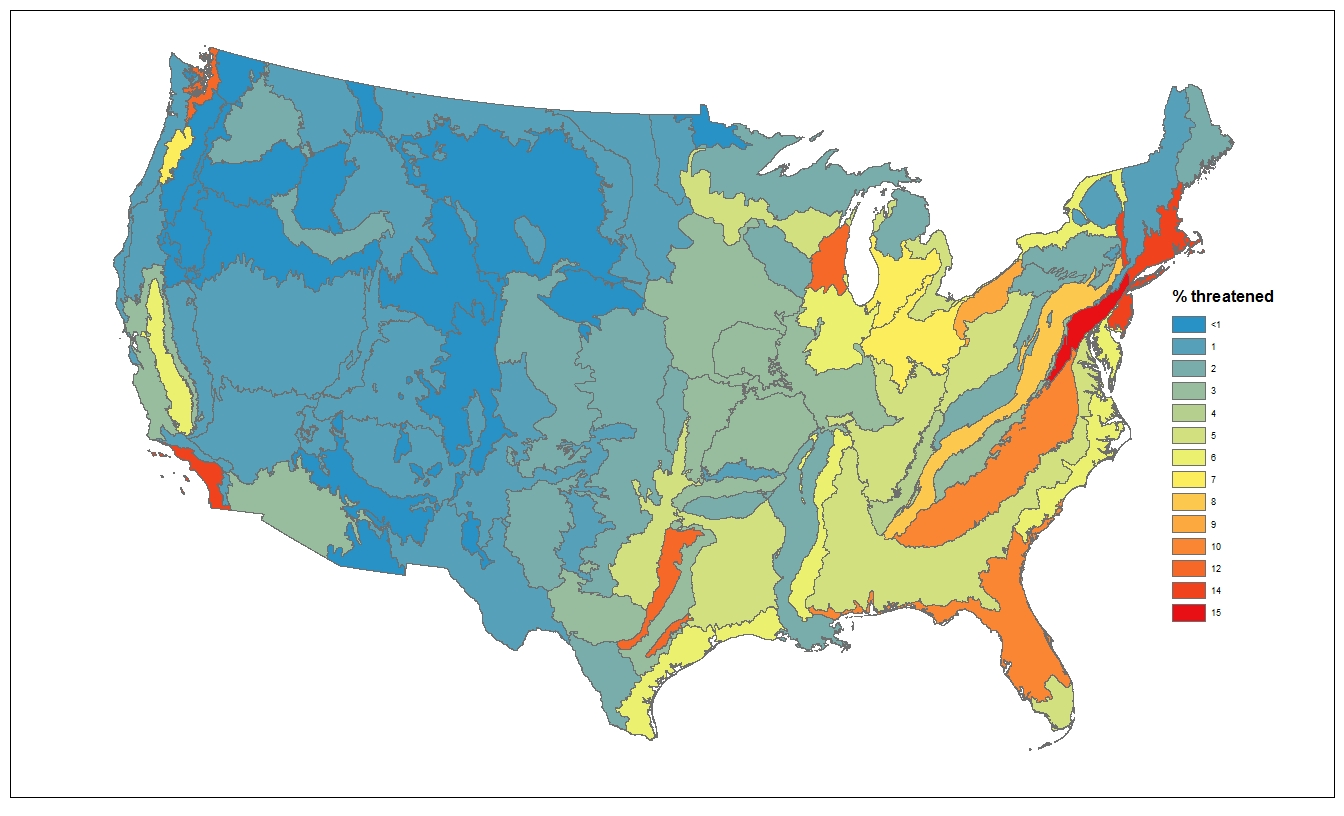
what if it's pathed to the web:
![L3_percentThreatened.jpg](https://raw.githubusercontent.com/usgs-bis/expected-land-use-change/master/L3_percentThreatened.jpg)

#### Step 2:
Stepping down a level of ecological classification allows us to address how land use change may affect, or threaten, the various ecological systems of the US. We will do this by substituting the ecoregions used in Step 1, with the GAP land cover data and its ecological systems classification. This expands the number of categories from 85 ecoregions to XXX ecological systems. The script below is essentially the same as the example above. 

In [ ]:
import arcpy, os 
from arcpy import env
from arcpy.sa import *

# Set environment settings
env.overwriteOutput = True
env.workspace = "Z:/projects/GAP/DataReleaseCONUS/data/temp"

# Check out the ArcGIS Spatial Analyst extension license
arcpy.CheckOutExtension("Spatial")
rasterlist = arcpy.ListRasters() # Get a list of input rasters

#global values and CONUS ecological systems
inZoneData = r"W:\Projects\GAP\Nat_GAP_LandCover\natgaplandcov_v2_2_1.img"
zoneField = "ECOLSYS_LU" #can change to different types
classData = "Z:/projects/GAP/DataReleaseCONUS/data/Threat30m.tif" 
classField = "VALUE" 
outTable = "ecoSysMasterTable.dbf"
processingCellSize = 30
arcpy.env.snapRaster = classData
arcpy.env.extent = classData
TabulateArea(inZoneData, zoneField, classData, classField, outTable, processingCellSize)

# work on output table, add 8 field names, 
#arcpy.AddField_management(outTable, "L3eco", 'TEXT')
arcpy.AddField_management(outTable, "NoThreat", 'FLOAT')
arcpy.AddField_management(outTable, "LowThreat", 'FLOAT')
arcpy.AddField_management(outTable, "MedThreat", 'FLOAT')
arcpy.AddField_management(outTable, "HighThreat", 'FLOAT')
arcpy.AddField_management(outTable, "AllThreat", 'FLOAT')
arcpy.AddField_management(outTable, "Total", 'FLOAT')
arcpy.AddField_management(outTable, "Percent", 'FLOAT')

# convert to Ha, sum, %
arcpy.CalculateField_management(outTable, "NoThreat", "!VALUE_1!*0.0001", "PYTHON_9.3") 
arcpy.CalculateField_management(outTable, "LowThreat", "!VALUE_2!*0.0001", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "MedThreat", "!VALUE_3!*0.0001", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "HighThreat", "!VALUE_4!*0.0001", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "AllThreat", "sum([!LowThreat!, !MedThreat!, !HighThreat!])", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "Total", "sum([!NoThreat!,!LowThreat!, !MedThreat!, !HighThreat!])", "PYTHON_9.3")
arcpy.CalculateField_management(outTable, "Percent", "(!AllThreat!/!Total!)*100","PYTHON_9.3")

The results of which should yield a .dbf table containing a unique row per ecological system class, and columns of the no/low/med/high threatened classes, total area, and the percent of the ecoligical system threatened. In the image below, the top fifty ecological systems in terms of percent threatened are in red. Those systems are names in table 1 below. 

this works locally but not on GitHub:
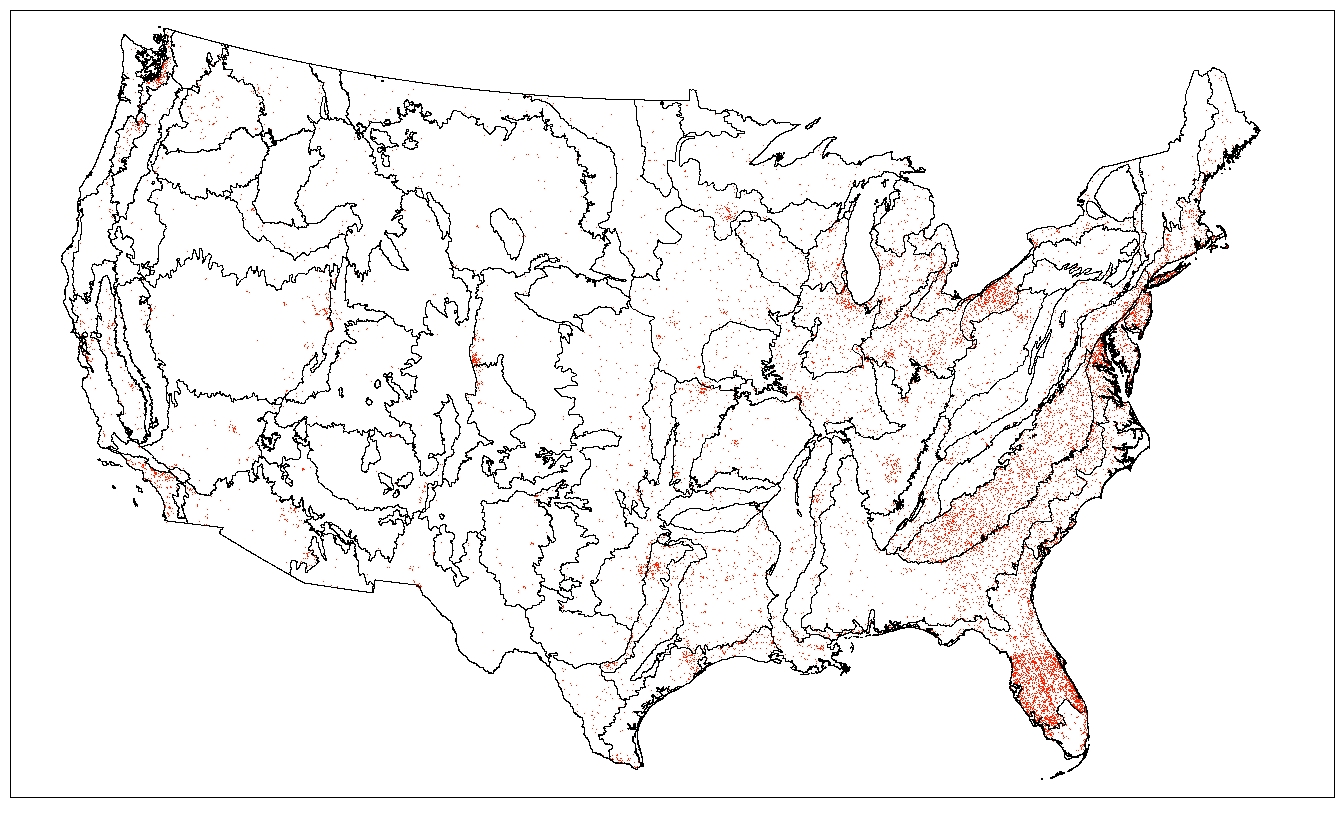
![ecologicalSystems.jpg](https://raw.githubusercontent.com/usgs-bis/expected-land-use-change/master/ecologicalSystems.jpg)

##### Table 1: The top fifty ecological systems in terms of percent threatened for CONUS USA

| Ecological Systems                                                                   | NoThreat | LowThreat | MedThreat | HighThreat | AllThreat | Total   | Percent |
|--------------------------------------------------------------------------------------|----------|-----------|-----------|------------|-----------|---------|---------|
| Laurentian-Acadian Alkaline Conifer-Hardwood Swamp                                   | 0.18     | 0         | 0         | 0.54       | 0.54      | 0.72    | 75      |
| Atlantic Coastal Plain Central Maritime Forest                                       | 10906.8  | 505.62    | 288.27    | 3990.87    | 4784.76   | 15691.6 | 30.4925 |
| West Gulf Coastal Plain Nepheline Syenite Glade                                      | 38.88    | 4.59      | 3.42      | 6.39       | 14.4      | 53.28   | 27.027  |
| Southwest Florida Dune and Coastal Grassland                                         | 3810.33  | 69.03     | 43.74     | 988.2      | 1100.97   | 4911.3  | 22.4171 |
| Central Appalachian Floodplain - Forest Modifier                                     | 3140.82  | 124.92    | 100.17    | 651.24     | 876.33    | 4017.15 | 21.8147 |
| Central Florida Pine Flatwoods                                                       | 24682.9  | 788.76    | 597.33    | 4929.21    | 6315.3    | 30998.2 | 20.3731 |
| East Gulf Coastal Plain Maritime Forest                                              | 36160.2  | 907.2     | 576       | 7284.51    | 8767.71   | 44927.9 | 19.5151 |
| Atlantic Coastal Plain Southern Maritime Forest                                      | 118865   | 3898.53   | 2251.44   | 22642.9    | 28792.9   | 147658  | 19.4997 |
| Southern Piedmont Dry Oak-(Pine) Forest                                              | 33.21    | 0.81      | 0.36      | 6.75       | 7.92      | 41.13   | 19.256  |
| Central Appalachian Riparian - Forest Modifier                                       | 7528.95  | 243.81    | 144.54    | 1320.12    | 1708.47   | 9237.42 | 18.4951 |
| West Gulf Coastal Plain Chenier and Upper Texas Coastal Fringe Forest and Woodland   | 9699.03  | 325.71    | 204.12    | 1630.98    | 2160.81   | 11859.8 | 18.2196 |
| Central Florida Herbaceous Pondshore                                                 | 13308.6  | 303.39    | 200.07    | 2349.45    | 2852.91   | 16161.5 | 17.6525 |
| Atlantic Coastal Plain Clay-Based Carolina Bay Herbaceous Wetland                    | 127.44   | 3.78      | 2.7       | 19.35      | 25.83     | 153.27  | 16.8526 |
| Southern Ridge and Valley / Cumberland Dry Calcareous Forest                         | 671.94   | 41.4      | 18.63     | 75.15      | 135.18    | 807.12  | 16.7484 |
| Great Lakes Wet-Mesic Lakeplain Prairie                                              | 5326.47  | 177.39    | 110.52    | 783.27     | 1071.18   | 6397.65 | 16.7433 |
| Introduced Upland Vegetation - Treed                                                 | 38201.3  | 1305.99   | 878.13    | 5070.69    | 7254.81   | 45456.1 | 15.96   |
| Northern California Claypan Vernal Pool                                              | 2623.05  | 157.68    | 55.44     | 280.8      | 493.92    | 3116.97 | 15.8462 |
| Southern Piedmont Glade and Barrens                                                  | 10.53    | 0         | 0         | 1.98       | 1.98      | 12.51   | 15.8273 |
| South Florida Pine Flatwoods                                                         | 424960   | 7065.72   | 4652.91   | 65148.1    | 76866.7   | 501827  | 15.3174 |
| Nashville Basin Limestone Glade                                                      | 54236.2  | 1753.02   | 835.29    | 7033.77    | 9622.08   | 63858.3 | 15.0679 |
| North-Central Interior Wet Flatwoods                                                 | 86947.8  | 2435.22   | 1339.29   | 11535.6    | 15310.1   | 102258  | 14.972  |
| Florida Longleaf Pine Sandhill- Open Understory Modifier                             | 133978   | 3902.58   | 3034.26   | 16544.3    | 23481.1   | 157459  | 14.9125 |
| Southern Coastal Plain Seepage Swamp and Baygall                                     | 57829.6  | 1388.88   | 897.93    | 7833.96    | 10120.8   | 67950.4 | 14.8944 |
| Southern Piedmont Granite Flatrock                                                   | 1440.36  | 61.83     | 24.84     | 150.21     | 236.88    | 1677.24 | 14.1232 |
| North Pacific Shrub Swamp                                                            | 45048.5  | 1644.39   | 802.26    | 4957.74    | 7404.39   | 52452.9 | 14.1163 |
| Atlantic Coastal Plain Northern Maritime Forest                                      | 32869.6  | 978.12    | 645.57    | 3571.56    | 5195.25   | 38064.9 | 13.6484 |
| Southern Coastal Plain Hydric Hammock                                                | 624213   | 12183.8   | 7887.96   | 73937.8    | 94009.6   | 718223  | 13.0892 |
| Atlantic Coastal Plain Northern Fresh and Oligohaline Tidal Marsh                    | 32743.6  | 691.74    | 508.23    | 3601.17    | 4801.14   | 37544.7 | 12.7878 |
| Deciduous Plantations                                                                | 503654   | 12757     | 7140.69   | 53444.1    | 73341.8   | 576996  | 12.711  |
| Atlantic Coastal Plain Southern Tidal Wooded Swamp                                   | 22937    | 320.22    | 192.15    | 2780.28    | 3292.65   | 26229.7 | 12.5531 |
| Atlantic Coastal Plain Northern Tidal Wooded Swamp                                   | 15298.2  | 342.99    | 257.22    | 1580.94    | 2181.15   | 17479.3 | 12.4785 |
| Temperate Pacific Freshwater Aquatic Bed                                             | 213.3    | 12.96     | 7.38      | 9.45       | 29.79     | 243.09  | 12.2547 |
| Atlantic Coastal Plain Fall-line Sandhills Longleaf Pine Woodland - Offsite Hardwood | 102185   | 2275.11   | 1152.72   | 10324.1    | 13751.9   | 115937  | 11.8615 |
| Northern Atlantic Coastal Plain Dry Hardwood Forest                                  | 229130   | 6170.13   | 3901.86   | 20434.9    | 30506.9   | 259637  | 11.7498 |
| Southern Piedmont Dry Oak-(Pine) Forest - Loblolly Pine Modifier                     | 597444   | 12062.6   | 6644.88   | 60269      | 78976.5   | 676421  | 11.6756 |
| Texas Blackland Tallgrass Prairie                                                    | 71217.5  | 1559.25   | 747.18    | 7087.32    | 9393.75   | 80611.3 | 11.6531 |
| Florida Peninsula Inland Scrub                                                       | 77890.3  | 1634.04   | 1046.43   | 7564.77    | 10245.2   | 88135.5 | 11.6244 |
| Southern Piedmont Small Floodplain and Riparian Forest                               | 429698   | 8289.27   | 4525.92   | 43444.6    | 56259.8   | 485958  | 11.5771 |
| Texas-Louisiana Coastal Prairie                                                      | 56709.7  | 1130.4    | 526.5     | 5652.09    | 7308.99   | 64018.7 | 11.417  |
| North-Central Interior Beech-Maple Forest                                            | 908540   | 21822.1   | 11748.9   | 82666.1    | 116237    | 1024780 | 11.3426 |
| East Gulf Coastal Plain Savanna and Wet Prairie                                      | 38817.7  | 858.51    | 515.43    | 3557.43    | 4931.37   | 43749.1 | 11.2719 |
| Southern Ridge and Valley Dry Calcareous Forest - Pine modifier                      | 126272   | 3775.77   | 1946.61   | 10297.9    | 16020.3   | 142292  | 11.2587 |
| Atlantic Coastal Plain Southern Wet Pine Savanna and Flatwoods                       | 94273.6  | 1905.57   | 1178.82   | 8609.76    | 11694.2   | 105968  | 11.0356 |
| East Gulf Coastal Plain Northern Loess Plain Oak-Hickory Upland - Juniper Modifier   | 27433.5  | 585.99    | 345.06    | 2416.05    | 3347.1    | 30780.6 | 10.8741 |
| Atlantic Coastal Plain Dry and Dry-Mesic Oak Forest                                  | 1648430  | 39701.4   | 21860.5   | 136787     | 198349    | 1846780 | 10.7403 |
| East Gulf Coastal Plain Near-Coast Pine Flatwoods                                    | 4421.34  | 133.11    | 74.61     | 321.75     | 529.47    | 4950.81 | 10.6946 |
| Southern Piedmont Mesic Forest                                                       | 617458   | 12335.9   | 6629.22   | 54634      | 73599.1   | 691057  | 10.6502 |
| Southern Piedmont/Ridge and Valley Upland Depression Swamp                           | 195.84   | 5.67      | 0.45      | 17.1       | 23.22     | 219.06  | 10.5998 |
| Floridian Highlands Freshwater Marsh                                                 | 335165   | 5231.61   | 3064.95   | 30993.5    | 39290.1   | 374455  | 10.4926 |
| Northern Atlantic Coastal Plain Pitch Pine Barrens                                   | 7503.21  | 189.9     | 170.1     | 518.4      | 878.4     | 8381.61 | 10.4801 |

#### Step 3:
Now we will use 2 different scripts to calculate how the threat layer will affect ecological systems by ecoregion. This will use the GAP land cover layer to get data on ecological systems. The first, "splitClipL3.py" clips the threat data into an individual raster per ecoregion. The second, "ecolSysThreatCalc.py" takes those clipped input files and determines the area threated for each ecological system. 

Two preprocessing steps are ommited: 1.) the EPA L3 ecoregion shapefile needs to be dissolved (simplified) based on the column 'US_L3code', and 2.) a column named "ID" is added as an integer and takes the value of 'US_L3code'. The result is shapefile with 85 rows in the attribute table and a numeric ID corresponding to the ecoregion code. 

In [7]:
import arcpy, os

arcpy.env.workspace = r"Z:\projects\GAP\DataReleaseCONUS\data" # Where the clip shapefile and input raster are stored
outputWorkspace = r"Z:\projects\GAP\DataReleaseCONUS\data\temp" # Where the output images will be stored
arcpy.env.overwriteOutput = True

rasterlist = arcpy.ListRasters() # Get a list of input rasters

clipShapefile = r"us_eco_l3_no_st_dissolve.shp" # Clip shapefile

# Create set of FIDs in the clip shapefile
clipShapes = set()
with arcpy.da.SearchCursor(clipShapefile, ['ID']) as cursor: #NEED to add an ID column that = US_L3CODE? or just change ID below
    for row in cursor:
        clipShapes.add(row[0])

# Loop through input rasters, and clip by each shape in the input shapefile
for raster in rasterlist:
    rastername, rasterext = os.path.splitext(raster)
    for i in clipShapes:
        j=str(i)
        print j 
        j=j.zfill(2) # pads 1-9 with a 0 for filenaming
        newRaster = "{}_clip_{}.tif".format(rastername, j)
        newRasterPath = os.path.join(outputWorkspace, newRaster)
        if arcpy.Exists('clipLayer'): # Remove existing 'clipLayer' feature layer if it still exists for some reason
            arcpy.Delete_management('clipLayer')
        arcpy.MakeFeatureLayer_management(clipShapefile, 'clipLayer', ' "ID" = {}'.format(i)) #create a layer with only polygon i
        arcpy.Clip_management(raster, "#", newRasterPath, 'clipLayer', "0", "ClippingGeometry") #clip based on layer, clipping geometry will use the polygon extent only
        arcpy.Delete_management('clipLayer')


ImportError: No module named arcpy

Now we have a directory \data\temp where 85 raster clips of the threat data exist, one for each ecoregion. In the next script we use the GAP land cover layer to assess how ecological systems could be affected by threats from land use change. 

In [6]:
# Name: ecolSysThreatCalc.py
# Description: calculates 'threat' from land use change projections
# Requirements: Spatial Analyst Extension
# Author: Jason Kreitler
# Comments: 
##########################################################################

import arcpy, os 
from arcpy import env
from arcpy.sa import *

# Set environment settings
env.overwriteOutput = True
env.workspace = "Z:/projects/GAP/DataReleaseCONUS/data/temp"

# Check out the ArcGIS Spatial Analyst extension license
arcpy.CheckOutExtension("Spatial")
rasterlist = arcpy.ListRasters() # Get a list of input rasters

# now loop through rasters in /data/temp and tabulate area 
# of each ecological system (or other) that falls in a threat class

#global values
inZoneData = r"W:\Projects\GAP\Nat_GAP_LandCover\natgaplandcov_v2_2_1.img"
zoneField = "ECOLSYS_LU" #can change to different types

# # Loop through input rasters, 
for raster in rasterlist:
    rastername, rasterext = os.path.splitext(raster)
    inClassData = raster
    classField = "VALUE" 
    outTable = os.path.join(env.workspace, "ecolSys_" + rastername + ".dbf")
    processingCellSize = 30
    arcpy.env.snapRaster = raster
    arcpy.env.extent = raster 
    L3eco=rastername[-2:] #last 2 digits of the name (doesn't have file ext)
    expression = str(L3eco) #make it an expression for calculate field below
    
    if os.path.isfile(outTable):
        print L3eco + "...is already done"    
    else:
    	print "working on..." + L3eco 
    	# Execute TabulateArea
    	TabulateArea(inZoneData, zoneField, inClassData, classField, outTable, processingCellSize)

    	# work on output table, add 8 field names, 
    	arcpy.AddField_management(outTable, "L3eco", 'TEXT')
    	arcpy.AddField_management(outTable, "NoThreat", 'FLOAT')
    	arcpy.AddField_management(outTable, "LowThreat", 'FLOAT')
    	arcpy.AddField_management(outTable, "MedThreat", 'FLOAT')
    	arcpy.AddField_management(outTable, "HighThreat", 'FLOAT')
    	arcpy.AddField_management(outTable, "AllThreat", 'FLOAT')
    	arcpy.AddField_management(outTable, "Total", 'FLOAT')
    	arcpy.AddField_management(outTable, "Percent", 'FLOAT')
    	
    	# convert to Ha, sum, %
    	arcpy.CalculateField_management(outTable, "NoThreat", "!VALUE_1!*0.0001", "PYTHON_9.3") 
    	arcpy.CalculateField_management(outTable, "LowThreat", "!VALUE_2!*0.0001", "PYTHON_9.3")
    	arcpy.CalculateField_management(outTable, "MedThreat", "!VALUE_3!*0.0001", "PYTHON_9.3")
    	arcpy.CalculateField_management(outTable, "HighThreat", "!VALUE_4!*0.0001", "PYTHON_9.3")
    	arcpy.CalculateField_management(outTable, "AllThreat", "sum([!LowThreat!, !MedThreat!, !HighThreat!])", "PYTHON_9.3")
    	arcpy.CalculateField_management(outTable, "Total", "sum([!NoThreat!,!LowThreat!, !MedThreat!, !HighThreat!])", "PYTHON_9.3")
    	arcpy.CalculateField_management(outTable, "Percent", "(!AllThreat!/!Total!)*100","PYTHON_9.3")
    	arcpy.CalculateField_management(outTable, "L3eco", '"'+expression+'"',"PYTHON_9.3")

# now clean up the tables by merging to one
masterTable=r'Z:\projects\GAP\DataReleaseCONUS\data\temp\masterTable.dbf'
dbfList = arcpy.ListTables()
arcpy.Merge_management(dbfList,masterTable)

ImportError: No module named arcpy

This script should generate a table ("masterTable.dbf") in the \temp folder, where each ecological system type within a L3 ecoregion will have a separate row, and columns for the threat levels, total area, and the percent threatened. 

In the example below from Southern California (one of the most threated ecoregions), the table shows the variation in values of threat calculated. These ecological systems may be represented in other ecoregions, but this region has a very large proportion of highly threatened ecological systems. 

| Ecological Systems                                                    | L3eco | NoThreat | LowThreat | MedThreat | HighThreat | AllThreat | Total   | Percent   |
|-----------------------------------------------------------------------|-------|----------|-----------|-----------|------------|-----------|---------|-----------|
| California Lower Montane Blue Oak-Foothill Pine Woodland and Savanna  | 85    | 4271.4   | 191.79    | 114.93    | 1986.3     | 2293.02   | 6564.42 | 34.931    |
| Mediterranean California Mesic Serpentine Woodland and Chaparral      | 85    | 2813.04  | 204.93    | 96.03     | 842.49     | 1143.45   | 3956.49 | 28.9006   |
| California Central Valley Mixed Oak Savanna                           | 85    | 14479.7  | 512.55    | 314.64    | 4684.05    | 5511.24   | 19990.9 | 27.5687   |
| California Central Valley Riparian Woodland and Shrubland             | 85    | 1281.6   | 31.59     | 27.36     | 381.87     | 440.82    | 1722.42 | 25.5931   |
| California Maritime Chaparral                                         | 85    | 154.35   | 3.78      | 5.31      | 38.79      | 47.88     | 202.23  | 23.676    |
| California Central Valley and Southern Coastal Grassland              | 85    | 158133   | 4204.26   | 2803.32   | 42020.3    | 49027.9   | 207161  | 23.6666   |
| North American Warm Desert Riparian Woodland and Shrubland            | 85    | 779.22   | 20.16     | 9.54      | 203.4      | 233.1     | 1012.32 | 23.0263   |
| Sonora-Mojave Mixed Salt Desert Scrub                                 | 85    | 711.36   | 16.11     | 13.05     | 167.85     | 197.01    | 908.37  | 21.6883   |
| California Mesic Serpentine Grassland                                 | 85    | 171.72   | 8.73      | 4.95      | 29.52      | 43.2      | 214.92  | 20.1005   |
| Inter-Mountain Basins Big Sagebrush Shrubland                         | 85    | 252      | 4.5       | 3.42      | 47.61      | 55.53     | 307.53  | 18.0568   |
| California Coastal Closed-Cone Conifer Forest and Woodland            | 85    | 832.77   | 24.39     | 13.77     | 145.26     | 183.42    | 1016.19 | 18.0498   |
| Southern California Coastal Scrub                                     | 85    | 389001   | 9254.07   | 5781.87   | 66425.4    | 81461.3   | 470462  | 17.3152   |
| Southern California Oak Woodland and Savanna                          | 85    | 15002.1  | 549.36    | 304.02    | 2042.82    | 2896.2    | 17898.3 | 16.1814   |
| North American Warm Desert Pavement                                   | 85    | 44.28    | 0.63      | 0.72      | 5.85       | 7.2       | 51.48   | 13.986    |
| Sonora-Mojave Creosotebush-White Bursage Desert Scrub                 | 85    | 7215.3   | 123.3     | 89.64     | 939.33     | 1152.27   | 8367.57 | 13.7707   |
| North American Warm Desert Bedrock Cliff and Outcrop                  | 85    | 4129.2   | 121.23    | 58.77     | 476.73     | 656.73    | 4785.93 | 13.7221   |
| California Coastal Live Oak Woodland and Savanna                      | 85    | 83060    | 1578.15   | 1038.6    | 10547.3    | 13164     | 96224   | 13.6806   |
| Mediterranean California Foothill and Lower Montane Riparian Woodland | 85    | 17332.4  | 176.85    | 99.45     | 1873.44    | 2149.74   | 19482.1 | 11.0344   |
| Temperate Pacific Freshwater Emergent Marsh                           | 85    | 2512.26  | 19.35     | 22.14     | 255.42     | 296.91    | 2809.17 | 10.5693   |
| Southern California Dry-Mesic Chaparral                               | 85    | 174789   | 3129.66   | 1846.35   | 15325.3    | 20301.3   | 195090  | 10.4061   |
| California Coastal Redwood Forest                                     | 85    | 1775.34  | 30.33     | 14.04     | 149.85     | 194.22    | 1969.56 | 9.86109   |
| Great Basin Pinyon-Juniper Woodland                                   | 85    | 12782.2  | 243.81    | 121.05    | 868.86     | 1233.72   | 14015.9 | 8.80229   |
| Inter-Mountain Basins Shale Badland                                   | 85    | 464.67   | 3.15      | 3.6       | 34.83      | 41.58     | 506.25  | 8.21333   |
| Temperate Pacific Freshwater Mudflat                                  | 85    | 1035.09  | 8.28      | 9.18      | 60.75      | 78.21     | 1113.3  | 7.02506   |
| Inter-Mountain Basins Mixed Salt Desert Scrub                         | 85    | 220.41   | 0.54      | 0.54      | 12.87      | 13.95     | 234.36  | 5.95238   |
| North American Warm Desert Active and Stabilized Dune                 | 85    | 20.34    | 0.27      | 0.18      | 0.81       | 1.26      | 21.6    | 5.83333   |
| Mojave Mid-Elevation Mixed Desert Scrub                               | 85    | 5233.5   | 74.34     | 30.69     | 171.81     | 276.84    | 5510.34 | 5.02401   |
| Temperate Pacific Tidal Salt and Brackish Marsh                       | 85    | 2520.45  | 14.13     | 10.26     | 92.25      | 116.64    | 2637.09 | 4.42306   |
| California Mesic Chaparral                                            | 85    | 9609.84  | 52.02     | 26.64     | 308.7      | 387.36    | 9997.2  | 3.87468   |
| Mediterranean California Coastal Bluff                                | 85    | 12.78    | 0.09      | 0         | 0.36       | 0.45      | 13.23   | 3.40136   |
| Mediterranean California Southern Coastal Dune                        | 85    | 3379.59  | 7.83      | 4.59      | 88.11      | 100.53    | 3480.12 | 2.88869   |
| Southern California Coast Ranges Cliff and Canyon                     | 85    | 3200.85  | 16.2      | 9.27      | 55.98      | 81.45     | 3282.3  | 2.48149   |
| Mediterranean California Dry-Mesic Mixed Conifer Forest and Woodland  | 85    | 1800.27  | 0.72      | 0.81      | 3.42       | 4.95      | 1805.22 | 0.274205  |
| Central and Southern California Mixed Evergreen Woodland              | 85    | 241.47   | 0.09      | 0         | 0          | 0.09      | 241.56  | 0.0372578 |
| Mediterranean California Mixed Evergreen Forest                       | 85    | 107.01   | 0         | 0         | 0          | 0         | 107.01  | 0         |
| California Montane Jeffrey Pine-(Ponderosa Pine) Woodland             | 85    | 425.88   | 0         | 0         | 0          | 0         | 425.88  | 0         |
| California Xeric Serpentine Chaparral                                 | 85    | 0.63     | 0         | 0         | 0          | 0         | 0.63    | 0         |
| Northern and Central California Dry-Mesic Chaparral                   | 85    | 0.45     | 0         | 0         | 0          | 0         | 0.45    | 0         |
| Sonora-Mojave Semi-Desert Chaparral                                   | 85    | 88.2     | 0         | 0         | 0          | 0         | 88.2    | 0         |
| California Montane Woodland and Chaparral                             | 85    | 0.45     | 0         | 0         | 0          | 0         | 0.45    | 0         |
| Mediterranean California Northern Coastal Dune                        | 85    | 4.32     | 0         | 0         | 0          | 0         | 4.32    | 0         |
| Mediterranean California Eelgrass Bed                                 | 85    | 1.26     | 0         | 0         | 0          | 0         | 1.26    | 0         |